In [1]:
import pandas as pd
import sys
import os
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if path not in sys.path:
    sys.path.append(path)
from constants import NER
# get the first key in NERa
from fuzzywuzzy import fuzz
from constants import NER
from fuzzywuzzy import fuzz
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
# import sklearn_crfsuite
import sklearn_crfsuite
from joblib import Parallel, delayed
import multiprocessing
from transformers import pipeline
from utils.helpers import combine_sub_words
from transformers import AutoTokenizer, AutoModelForTokenClassification


c:\Users\nasser\.conda\envs\finall\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
c:\Users\nasser\.conda\envs\finall\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# df = pd.read_csv('../data/data_for_ner.csv')

In [3]:
# df = df.sample(1000)

In [4]:
# def process_word(word, NER):
#     for key in NER.keys():
#         if any(fuzz.ratio(word, k) >= 80 for k in key):
#             return NER[key]
#     return "O"

In [5]:
# def generate_ner_string(text, NER):
#     num_cores = multiprocessing.cpu_count()
#     words = text.split()
#     results = Parallel(n_jobs=num_cores)(
#         delayed(process_word)(word, NER) for word in words)
#     return " ".join(results)

In [6]:
# df['ner'] = Parallel(n_jobs=-1)(
#     delayed(generate_ner_string)(text, NER) for text in df['full_text'])

In [7]:
# # get the rows with empty ner ""
# df[df['ner'] == '']
    

In [8]:
# df.to_csv('../data/data_with_near_v1.csv', index=False)

In [9]:
df = pd.read_csv('../data/data_with_near_v1.csv')

In [10]:
# model_name = "CAMeL-Lab/bert-base-arabic-camelbert-ca-pos-egy"
# tokenizer = AutoTokenizer.from_pretrained(model_name) # how to make the tokinzation on split by space?

# pos_pipeline = pipeline("ner", model=model_name, tokenizer=tokenizer)

In [11]:
# # remove any punctuation from the full text
# df['full_text'] = df['full_text'].str.replace(r'[^\u0600-\u06FF\s]+', '')
# df['full_text'] = df['full_text'].str.replace(r'\?|؟|،', '')


In [12]:
# pos_list = []
# for text in df['full_text']:
#     # remove any punctuation from the text
#     res = pos_pipeline(text)
#     res = combine_sub_words(res)
#     while(1):
#         if any('##' in r['word'] for r in res):
#             res = combine_sub_words(res)
#         else:
#             break
#     res = [r['entity'] for r in res]
#     res = " ".join(res)
#     pos_list.append(res)
# df['pos'] = pos_list


In [13]:
# df['full_text_len'] = df['full_text'].apply(lambda x: len(x.split()))
# # df['pos_len'] = df['pos'].apply(lambda x: len(x.split()))

In [14]:
# pd.set_option('display.max_colwidth', None)
# df[['full_text','pos', 'full_text_len', 'pos_len']]
# # print the rows that have different length
# df[df['full_text_len'] != df['pos_len']]
# # remove the rows that have different length
# df = df[df['full_text_len'] == df['pos_len']]

In [15]:
# df.shape

In [16]:
# df = df[['full_text', 'pos', 'ner']]

In [17]:
data = df

In [18]:
data['ner'] = data['ner'].astype(str)
data['ner'] = data['ner'].apply(lambda x: x.split())

In [19]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [20]:
# Split the data into training and validation datasets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)
# Tokenize the input sequence
input_tokenizer = Tokenizer( oov_token='UNK')
input_tokenizer.fit_on_texts(train_data['full_text'])
train_input_seq = input_tokenizer.texts_to_sequences(train_data['full_text'])
val_input_seq = input_tokenizer.texts_to_sequences(val_data['full_text'])

In [21]:
# Tokenize the output sequence
output_tokenizer = Tokenizer(filters='', lower=False)
output_tokenizer.fit_on_texts(train_data['ner'])
train_output_seq = output_tokenizer.texts_to_sequences(train_data['ner'])
val_output_seq = output_tokenizer.texts_to_sequences(val_data['ner'])

In [22]:
# Create word to index and index to word mappings for the input sequence
input_word2idx = input_tokenizer.word_index
input_idx2word = {idx: word for word, idx in input_word2idx.items()}

In [23]:
# Create named entity to index and index to named entity mappings for the output sequence
output_word2idx = output_tokenizer.word_index
output_idx2word = {idx: word for word, idx in output_word2idx.items()}

In [24]:
# Pad the input sequence
max_input_len = max(len(seq) for seq in train_input_seq)
train_input_seq = pad_sequences(train_input_seq, maxlen=max_input_len, padding='post')
val_input_seq = pad_sequences(val_input_seq, maxlen=max_input_len, padding='post')

In [25]:
max_input_len
# Pad the output sequence
max_output_len = max(len(seq) for seq in train_output_seq)
train_output_seq = pad_sequences(train_output_seq, maxlen=max_output_len, padding='post')
val_output_seq = pad_sequences(val_output_seq, maxlen=max_output_len, padding='post')
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense

In [26]:
# Define the input and output dimensions for the model
input_dim = len(input_word2idx) + 1
output_dim = len(output_word2idx) + 1
# Define the embedding dimension
embedding_dim = 128

In [27]:
# Define the number of hidden units in the LSTM layer
hidden_units = 256
# import bidirectional LSTM
from tensorflow.keras.layers import Bidirectional
# import concatenate
from tensorflow.keras.layers import Concatenate,Input

In [28]:

from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, Dense,Dropout
from tensorflow.keras.models import Model


In [29]:
# # Define the input layer
# inputs = Input(shape=(max_input_len,))

# # Define the embedding layer
# embedding = Embedding(input_dim=input_dim, output_dim=embedding_dim)(inputs)

# # Define the Bidirectional LSTM layer
# lstm = Bidirectional(LSTM(hidden_units, return_sequences=True) )(embedding)
# lstm = Bidirectional(LSTM(hidden_units, return_sequences=True) )(lstm)
# # lstm = Bidirectional(LSTM(hidden_units, return_sequences=True) )(lstm)
# dense = Dense(128, activation='relu')(lstm)
# dense = Dense(64, activation='relu')(dense)
# dense = Dense(16, activation='relu')(dense)

# # Define the output layer
# outputs = Dense(output_dim, activation='softmax')(dense)

# # Define the model
# model = Model(inputs=inputs, outputs=outputs)

# # Define the input layer
# inputs = Input(shape=(max_input_len,))

# # Define the embedding layer
# embedding = Embedding(input_dim=input_dim, output_dim=embedding_dim)(inputs)

# # Define the Bidirectional LSTM layer
# lstm = Bidirectional(LSTM(hidden_units, return_sequences=True) )(embedding)
# lstm = Bidirectional(LSTM(hidden_units, return_sequences=True) )(lstm)
# # lstm = Bidirectional(LSTM(hidden_units, return_sequences=True) )(lstm)
# dense = Dense(128, activation='relu')(lstm)
# dense = Dense(64, activation='relu')(lstm)
# dense = Dense(16, activation='relu')(lstm)
# dense = Dense(8, activation='relu')(lstm)

# # Define the output layer
# outputs = Dense(output_dim, activation='softmax')(dense)

# # Define the model
# model = Model(inputs=inputs, outputs=outputs)

In [41]:
from keras.layers import Conv1D, GlobalMaxPooling1D, Dropout, BatchNormalization, Flatten, GRU, Attention

inputs = Input(shape=(max_input_len,))

# Define the embedding layer
embedding = Embedding(input_dim=input_dim, output_dim=embedding_dim)(inputs)



# Define the Bidirectional GRU layer
gru1 = Bidirectional(GRU(hidden_units, return_sequences=True))(embedding)
ltsm1 = Bidirectional(LSTM(hidden_units, return_sequences=True))(embedding)

# Add attention layer
attention = Attention()([gru1, ltsm1])

# Add dense layers
dense = Dense(256, activation='relu')(attention)
dense = BatchNormalization()(dense)
dropout = Dropout(0.5)(dense)


# Define the output layer
outputs = Dense(output_dim, activation='softmax')(dropout)

# Define the model
model = Model(inputs=inputs, outputs=outputs)


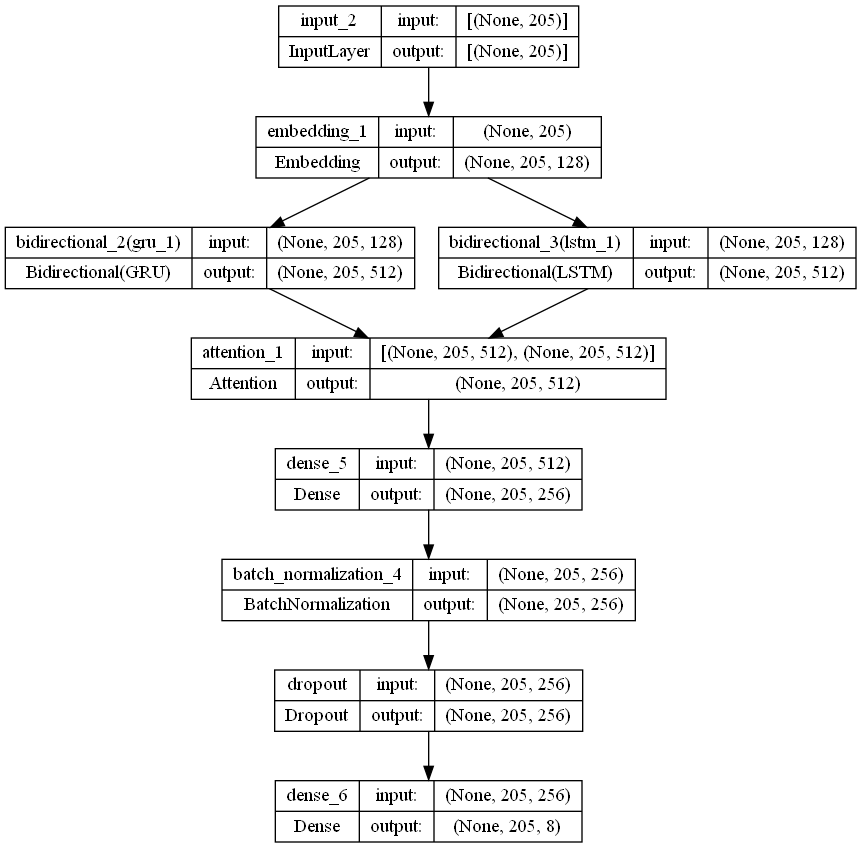

In [40]:
# draw the model
from tensorflow.keras.utils import plot_model
# draw it in the notebook
plot_model(model, show_shapes=True, show_layer_names=True)

In [42]:
# Compile the model
from tensorflow.keras.optimizers import Adam

learning_rate = 0.01  # Set the learning rate to 0.001

optimizer = Adam(learning_rate=learning_rate)

model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train the model
history = model.fit(train_input_seq, train_output_seq, validation_data=(val_input_seq, val_output_seq), batch_size=1048, epochs=15)

Epoch 1/15
30/30 [==============================] - 22s 606ms/step - loss: 0.4044 - accuracy: 0.9428 - val_loss: 2.5822 - val_accuracy: 0.9728
Epoch 2/15
30/30 [==============================] - 17s 568ms/step - loss: 0.0388 - accuracy: 0.9900 - val_loss: 2.6892 - val_accuracy: 0.9728
Epoch 3/15
30/30 [==============================] - 19s 637ms/step - loss: 0.0138 - accuracy: 0.9950 - val_loss: 1.0026 - val_accuracy: 0.9731
Epoch 4/15
30/30 [==============================] - 19s 631ms/step - loss: 0.0066 - accuracy: 0.9983 - val_loss: 0.3723 - val_accuracy: 0.9893
Epoch 5/15
30/30 [==============================] - 19s 625ms/step - loss: 0.0043 - accuracy: 0.9989 - val_loss: 0.1646 - val_accuracy: 0.9897
Epoch 6/15
30/30 [==============================] - 20s 680ms/step - loss: 0.0032 - accuracy: 0.9992 - val_loss: 0.0549 - val_accuracy: 0.9924
Epoch 7/15
30/30 [==============================] - 21s 688ms/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0208 - val_accuracy: 0.9971

In [51]:
import numpy as np
from sklearn.metrics import classification_report

# Generate predictions for the test set
y_pred = model.predict(val_input_seq)

# Convert predictions and ground-truth labels to flattened arrays
y_pred_flat = np.argmax(y_pred, axis=-1).flatten()
y_true_flat = val_output_seq.flatten()

# Get list of unique labels in the dataset
labels = list(set(y_true_flat))

# Generate classification report for each label
# add the label names to the classification report
output_idx2word
    



240/240 [==============================] - 6s 24ms/step


{1: 'O', 2: 'STAT', 3: 'B-LOC', 4: 'Barr', 5: 'I-LOC', 6: 'B-ORG', 7: 'I-ORG'}

In [50]:
print(classification_report(y_true_flat, y_pred_flat, labels=labels))

c:\Users\nasser\.conda\envs\finall\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\nasser\.conda\envs\finall\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1528062
           1       1.00      0.92      0.96     22322
           2       0.94      1.00      0.97      8269
           3       0.84      1.00      0.91      7127
           4       1.00      1.00      1.00      2787
           5       1.00      0.99      0.99      1402
           6       1.00      0.98      0.99       727
           7       0.00      0.00      0.00        14

    accuracy                           1.00   1570710
   macro avg       0.85      0.86      0.85   1570710
weighted avg       1.00      1.00      1.00   1570710



c:\Users\nasser\.conda\envs\finall\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:

# print the accuracy
print("Accuracy: ", history.history['accuracy'][-1])
# print the accuracy of validation set
print("Validation Accuracy: ", history.history['val_accuracy'][-1])

Accuracy:  0.9999361634254456
Validation Accuracy:  0.9988094568252563


In [55]:
import numpy as np
# Use the model to make predictions on new input data
text = "حاجز  شسيشس مفتوح"
# remove extra spaces
new_input_seq = input_tokenizer.texts_to_sequences([text])
new_input_seq = pad_sequences(new_input_seq, maxlen=max_input_len, padding='post')

pred_output_seq = model.predict(new_input_seq)
# set the index 0 of pred_output_seq to -inf for all words [0,this dynamic , 0]

pred_output_seq = np.argmax(pred_output_seq, axis=-1)

pred_named_entities = [output_idx2word.get(idx, '') for idx in pred_output_seq[0]]
print(pred_named_entities)
# map each word to its predicted named entity
for word, ner in zip(text.split(), pred_named_entities):
    print(f"{word} -> {ner}")

1/1 [==============================] - 0s 191ms/step
['Barr', 'B-LOC', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
شسيشس -> B-LOC
مفتوح -> STAT


In [20]:
import numpy as np
# Use the model to make predictions on new input data
text = "أنا على دير شرف سيسسالك"
# remove extra spaces
new_input_seq = input_tokenizer.texts_to_sequences([text])
new_input_seq = pad_sequences(new_input_seq, maxlen=max_input_len, padding='post')

pred_output_seq = model.predict(new_input_seq)
# set the index 0 of pred_output_seq to -inf for all words [0,this dynamic , 0]

pred_output_seq = np.argmax(pred_output_seq, axis=-1)

pred_named_entities = [output_idx2word.get(idx, '') for idx in pred_output_seq[0]]
print(pred_named_entities)
# map each word to its predicted named entity
for word, ner in zip(text.split(), pred_named_entities):
    print(f"{word} -> {ner}")

NameError: name 'max_input_len' is not defined

In [57]:
# save the model
model.save('../models/ner/ner_model.h5')

In [58]:
# save the tokenizer
import joblib
joblib.dump(input_tokenizer, '../models/ner/input_tokenizer.pkl')

['../models/ner/input_tokenizer.pkl']

In [60]:
# save the output_idx2word using joblib
joblib.dump(output_idx2word, '../models/ner/output_idx2word.pkl')


['../models/ner/output_idx2word.pkl']

In [2]:
# read the model
from tensorflow.keras.models import load_model
model = load_model('../models/ner/ner_model.h5')
# read the tokenizer
import joblib
input_tokenizer = joblib.load('../models/ner/input_tokenizer.pkl')
# read the output_idx2word
output_idx2word = joblib.load('../models/ner/output_idx2word.pkl')
    

In [25]:
import numpy as np
# Use the model to make predictions on new input data
text = "حاجز صرة ازمة للخارجين من نابلس"
# remove extra spaces
new_input_seq = input_tokenizer.texts_to_sequences([text])
new_input_seq = pad_sequences(new_input_seq, maxlen=205, padding='post')

pred_output_seq = model.predict(new_input_seq)
# set the index 0 of pred_output_seq to -inf for all words [0,this dynamic , 0]

pred_output_seq = np.argmax(pred_output_seq, axis=-1)


pred_named_entities = [output_idx2word.get(idx, '') for idx in pred_output_seq[0]]
print(pred_named_entities)
# map each word to its predicted named entity
for word, ner in zip(text.split(), pred_named_entities):
    print(f"{word} -> {ner}")

1/1 [==============================] - 0s 34ms/step
['Barr', 'B-LOC', 'STAT', 'O', 'O', 'O', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
حاجز -> Barr
صرة -> B-LOC
ازمة -> STAT
للخارجين -> O
من -> O
نابلس -> O


In [33]:
import numpy as np
# Use the model to make predictions on new input data
text = "الان ..دوار قدوميم سالك ونظيف "
# remove extra spaces
new_input_seq = input_tokenizer.texts_to_sequences([text])
new_input_seq = pad_sequences(new_input_seq, maxlen=205, padding='post')

pred_output_seq = model.predict(new_input_seq)
# set the index 0 of pred_output_seq to -inf for all words [0,this dynamic , 0]

pred_output_seq = np.argmax(pred_output_seq, axis=-1)

pred_named_entities = [output_idx2word.get(idx, '') for idx in pred_output_seq[0]]
print(pred_named_entities)
# map each word to its predicted named entity
for word, ner in zip(text.split(), pred_named_entities):
    print(f"{word} -> {ner}")

1/1 [==============================] - 0s 256ms/step
['O', 'Barr', 'B-LOC', 'STAT', 'STAT', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']
الان -> O
..دوار -> Barr
قدوميم -> B-LOC
سالك -> STAT
ونظيف -> STAT
